In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class GeneType():
    
    def __init__(self, Gene, alpha):
        # alpha = {division_rate:division, pasym, psym, dsym, 
        #          death_rate:death, v, compete:c, K, adjust,
        #          mul_division:dd, delta_psym:dp, delta_mute:dm}
        self.G = Gene
        self.alpha = alpha
        return
    
    def mutate(self, types):
        
        alpha = {key:self.alpha[key] for key in self.alpha}
        for mut in types:
            
            if len(self.G) >= 3:
                return self.get_attr(), self.get_alpha()
        
            if mut == "S":
                alpha["division"] *= alpha["dd"]
            elif mut == "F":
                r_before = (alpha["psym"]-alpha["dsym"])*alpha["division"]-alpha["death"]
                
                alpha["psym"] += alpha["dp"]
                alpha["pasym"] -= alpha["dp"]
                
                r_after = (alpha["psym"]-alpha["dsym"])*alpha["division"]-alpha["death"]
                
                alpha["K"] *= r_after/r_before
                
            else:
                alpha["v"] += alpha["dm"]

            self.G += mut
        
        self.alpha = alpha
        return self.get_attr(), self.get_alpha()
    
    def get_attr(self):
        alpha = self.alpha
        
        self.va = alpha["v"] * alpha["adjust"] / 2
        self.vs = alpha["v"] * alpha["adjust"]
        self.v = self.va * alpha["pasym"] + self.vs * alpha["psym"]
        self.K = alpha["K"]
        
        self.b = self.alpha["psym"] * self.alpha["division"]
        self.d = self.alpha["dsym"] * self.alpha["division"] + self.alpha["death"]
        self.r = self.b - self.d
        
        return {"b":self.b, "d":self.d, "r":self.r, "K":self.K, "G":self.G,
                "va":self.va, "vs":self.vs, "v":self.v}
    
    def get_alpha(self):
        return self.alpha

    
class tissue():
    
    def __init__(self, alpha, pfunc, 
                 eps, T, period, Gene="",
                 check = True):
        self.eps = eps
        self.ptrans = pfunc
        self.alpha = alpha
        self.T = T
        self.period = period
        self.para = GeneType(Gene, alpha).get_attr()
        self.ts = np.linspace(0, self.T, num=self.period)
        self.solution = {}
        if check:
            self.self_check()
    
    def self_check(self):
        self.excess_survive_rate = (self.para["d"]/self.para["b"]) * (self.eps*self.para["K"])**(-1)
        self.mutation_before_epsK = 1 - np.exp(
                        -self.para["v"]*self.eps*self.para["K"]/self.para["r"] * 
                         (np.log(self.para["r"]*self.eps*self.para["K"]/self.para["b"]) + 0.58)
                        )
        print("Excess Survival ratio : ", self.excess_survive_rate/(self.para["r"]/self.para["b"]))
        print("P(mutiation in [0,tao]): ", self.mutation_before_epsK)
    
    def density(self, ts, para):
        e_rGt = np.exp(-para["r"]*ts)
        return (para["r"]**2 * self.eps*para["K"])/para["b"] * e_rGt * \
                np.exp(-para["r"]*self.eps*para["K"] * e_rGt/para["b"])
    
    def get_Gene(self, G, alpha):
        return GeneType(G, alpha)
    
    def mutate(self, types):
        self.para, self.alpha = self.get_Gene(self.para["G"],self.alpha).mutate(types)
    
    def vGfunc(self, ts, para):
        erGt = np.exp(para["r"] * ts)
        return para["v"] * self.eps*para["K"]**2 * \
                erGt / (para["K"] + self.eps*para["K"]*(erGt - 1))
        
    def muiGUfunc(self, ts, mtype, para, alpha):
        GU, _ = self.get_Gene(para["G"], alpha).mutate(mtype)
        vG = self.vGfunc(ts, para)
        fGU = self.density(ts, GU)
        ds = (ts[-1] - ts[0]) / (len(ts)-1)
        coeff = self.ptrans(para["G"], mtype)*GU["r"] / GU["b"]
        return coeff * np.convolve(vG*ds, fGU)[:len(ts)]
    
    def evolve(self, ts, muiGU, qGU):
        ds = (ts[-1] - ts[0]) / (len(ts)-1)
        qGU_rev = qGU[::-1]
        aux = np.convolve(muiGU*ds, 1-qGU_rev)[:len(muiGU)]
        aux = aux[::-1]
        return np.exp(-aux)
        
    def solveAUX(self, ts, para, alpha):
        if para["G"]:
            print(para["G"], end="  ")
        if len(para["G"]) == 3 and "S" in para["G"] and "F" in para["G"]:
            self.solution[para["G"]] = np.zeros_like(ts)
            return np.zeros_like(ts)
        elif len(para["G"]) == 3:
            self.solution[para["G"]] = np.ones_like(ts)
            return np.ones_like(ts)
        else:
            qG = np.ones_like(ts)
            for U in "SFM":
                paraU,alphaU = self.get_Gene(para["G"], alpha).mutate(U)
                muiGU = self.muiGUfunc(ts, U, para, alpha)
                qG *= self.evolve(ts, muiGU, self.solveAUX(ts, paraU, alphaU))
            self.solution[para["G"]] = qG
            return qG
    
    def solve(self):
        self.solveAUX(self.ts,self.para,self.alpha)
        print("")
        return self.solution
        
    
def pGUfunc(G, U):
    F, S, M = 0, 0, 0
    for c in G:
        if c == "F":
            F += 1
        if c == "S":
            S += 1
    pdict = {"F":4/(1+F), "S":7/(1+S), "M":4}
#     pdict = {"F":4, "S":7, "M":7}
    return pdict[U] / (pdict["F"]+pdict["S"]+pdict["M"])
    

In [2]:
alpha = {"division":1.35, "death":0, "pasym":0.9, "psym":0.0525, "dsym":0.1-0.0525,
         "adjust":1.5*1e-2, "v":1e-6, "K":2e8/12, "dd":1.14794853, "dp":2.12*1e-3, "dm":5*1e-6}

TestNULL = tissue(alpha, pGUfunc,1e-5,52*80,52*80*10)
print(TestNULL.alpha)
solution = TestNULL.solve()
print("Done")

Excess Survival ratio :  0.05700000000000007
P(mutiation in [0,tao]):  0.0006222773523772984
{'v': 1e-06, 'dm': 4.9999999999999996e-06, 'pasym': 0.9, 'death': 0, 'dd': 1.14794853, 'K': 16666666.666666666, 'psym': 0.0525, 'dp': 0.0021200000000000004, 'adjust': 0.015, 'division': 1.35, 'dsym': 0.04750000000000001}
S  SS  SSS  SSF  SSM  SF  SFS  SFF  SFM  SM  SMS  SMF  SMM  F  FS  FSS  FSF  FSM  FF  FFS  FFF  FFM  FM  FMS  FMF  FMM  M  MS  MSS  MSF  MSM  MF  MFS  MFF  MFM  MM  MMS  MMF  MMM  
Done


In [3]:
solution[""]

array([0.93655665, 0.93659108, 0.93662549, ..., 1.        , 1.        ,
       1.        ])

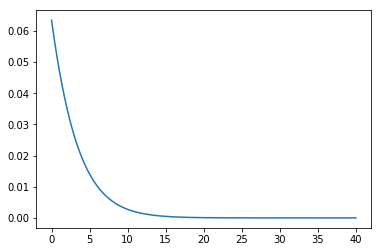

In [6]:
plt.plot(TestNULL.ts[:52*20*20]/52, 1-solution[""][:52*20*20], label='Line 1')
plt.show()

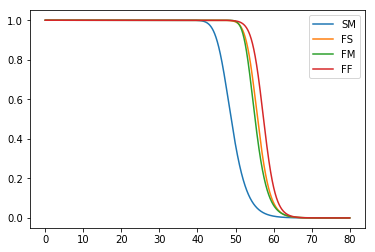

In [305]:
SM, = plt.plot(TestNULL.ts/52, 1-solution["SM"], label='Line 1')
FS, = plt.plot(TestNULL.ts/52, 1-solution["FS"], label='Line 2')
FM, = plt.plot(TestNULL.ts/52, 1-solution["FM"], label='Line 3')
FF, = plt.plot(TestNULL.ts/52, 1-solution["FF"], label='Line 4')
plt.legend([SM,FS,FM,FF], ['SM','FS','FM','FF'])
plt.show()

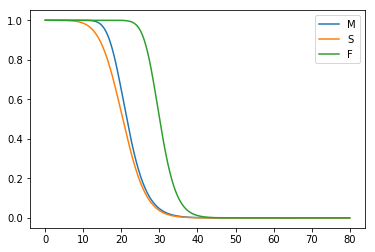

In [306]:
M, = plt.plot(TestNULL.ts/52, 1-solution["M"], label='Line 1')
S, = plt.plot(TestNULL.ts/52, 1-solution["S"], label='Line 2')
F, = plt.plot(TestNULL.ts/52, 1-solution["F"], label='Line 3')
plt.legend([M,S,F], ['M','S','F'])
plt.show()

In [21]:
test = np.linspace(0,0.99,num=1000)
true = np.exp(-(1-test)**3/6)
def evolve(ts, muiGU, qGU):
    ds = (ts[-1] - ts[0]) / (len(ts)-1)
    qGU_rev = qGU[::-1]
    aux = np.convolve(muiGU*ds, 1-qGU_rev)[:len(muiGU)]
    aux = aux[::-1]
    return np.exp(-aux)

np.mean((evolve(test, test, test) - true)/true)

2.254532194726022e-05

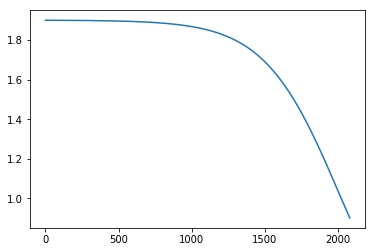

1.7186078999714165

In [325]:
import matplotlib.pyplot as plt
%matplotlib inline

def growth(ts, c, K, alpha, l):
    ds = (ts[-1]-ts[0])/(len(ts)-1)
    x = np.ones_like(ts)
    for i, t in enumerate(ts[:-1]):
        if x[i] < K:
            rate = c*np.exp(-1/(1-(x[i]/K)**alpha)) + l
        else:
            rate = l
        x[i+1] = x[i] + ds*x[i]*rate*0.005
    return x



ts = np.linspace(0,80*52,num=10000)
xx = growth(ts, 1.75*np.exp(1), 10**(8.3), 0.411731, 0.15)
plt.plot(ts[:-5001], 1/0.005 * np.diff(xx[:5000])*(len(ts)-1)/((ts[-1]-ts[0])*xx[:-5001]*(1-xx[:-5001]/(10**8.3))))
plt.show()

np.mean(1/0.005 * np.diff(xx[:5000])*(len(ts)-1)/((ts[-1]-ts[0])*xx[:-5001]*(1-xx[:-5001]/(10**8.3))))

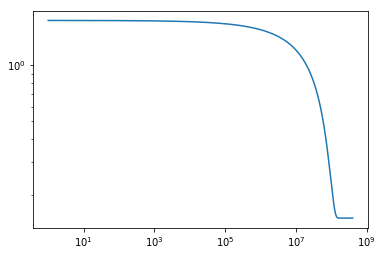

299280062.7286574

In [7]:
from scipy import stats

def growth(ns, K=10**8.301, p=0.41173119, c=np.exp(1)*1.6, d=0.15):
    res = np.zeros_like(ns)
    for i, n in enumerate(ns):
        if n >= K:
            res[i] = n*d
        else:
            res[i] = n*(c*np.exp(-1/(1-(n/K)**p)) + d)
    return res

KK = np.linspace(10**7, 10**8, num=10000)[np.argmax(growth(np.linspace(10**7, 10**8, num=10000)))]

plt.loglog(10**np.linspace(0, 8.6, num=10000), growth(10**np.linspace(0, 8.6, num=10000))/10**np.linspace(0, 8.6, num=10000))
plt.show()

stats.linregress(10**np.linspace(0, 8.7, num=10000),growth(10**np.linspace(0, 8.7, num=10000))/10**np.linspace(0, 8.7, num=10000))

1.5812997331580025 / 5.283678834936925e-09